In [1]:
# Importaciones iniciales
import sys
from collections import OrderedDict

from mne import create_info, concatenate_raws, preprocessing
from mne.io import RawArray
from mne.channels import read_montage
from mne.viz import plot_epochs_image

import pandas as pd
import numpy as np

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

# importar utilidades de muse-lsl
sys.path.append('../muse')
import utils

%matplotlib inline

In [28]:
# variables globales

# en esta lista voy a ir guardando los objetos epochs que serán usados
# como entrada a los clasificadores
clasificables = OrderedDict()

## Cargar datos desde muse
Se pueden leer datos del dispositivo y guardarlos en un .csv con la utilidad  `lsl-record.py` y `muse-lsl.py`  

Ejemplo: 

`sudo python muse-lsl.py --address 00:55:DA:B3:4C:6C`

`python stimulus_presentation/generate_Blinks.py & python lsl-record.py -d 60`

Un problema de esta utilidad es que espera un canal de eventos (markers). En este ejemplo dicho canal es provisto por generate_Blinks.py.

## Cargar datos CSV para entrenamiento
muse-lsl tiene una utilidad propia para cargar los datos de un .csv. Para utilizarla primero se deben guardar los datos bajo el directorio "data/<nombre>" e invocar la función utils.load_data(). La misma leerá todos los .csv bajo el directorio pasado como argumento y devolverá un objeto del tipo mne.raw.

In [4]:
# Carga los datos desde una carpeta. Espera archivos CSV
subject = 1
session = 1

raw_train = utils.load_data('train', sfreq=256., 
                      subject_nb=subject, session_nb=session, 
                      ch_ind=[0, 1, 2, 3])
#raw_train.info

Creating RawArray with float64 data, n_channels=5, n_times=9324
    Range : 0 ... 9323 =      0.000 ...    36.418 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=7692
    Range : 0 ... 7691 =      0.000 ...    30.043 secs
Ready.


/home/default/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/default/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/default/.conda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


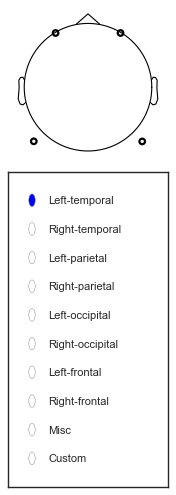

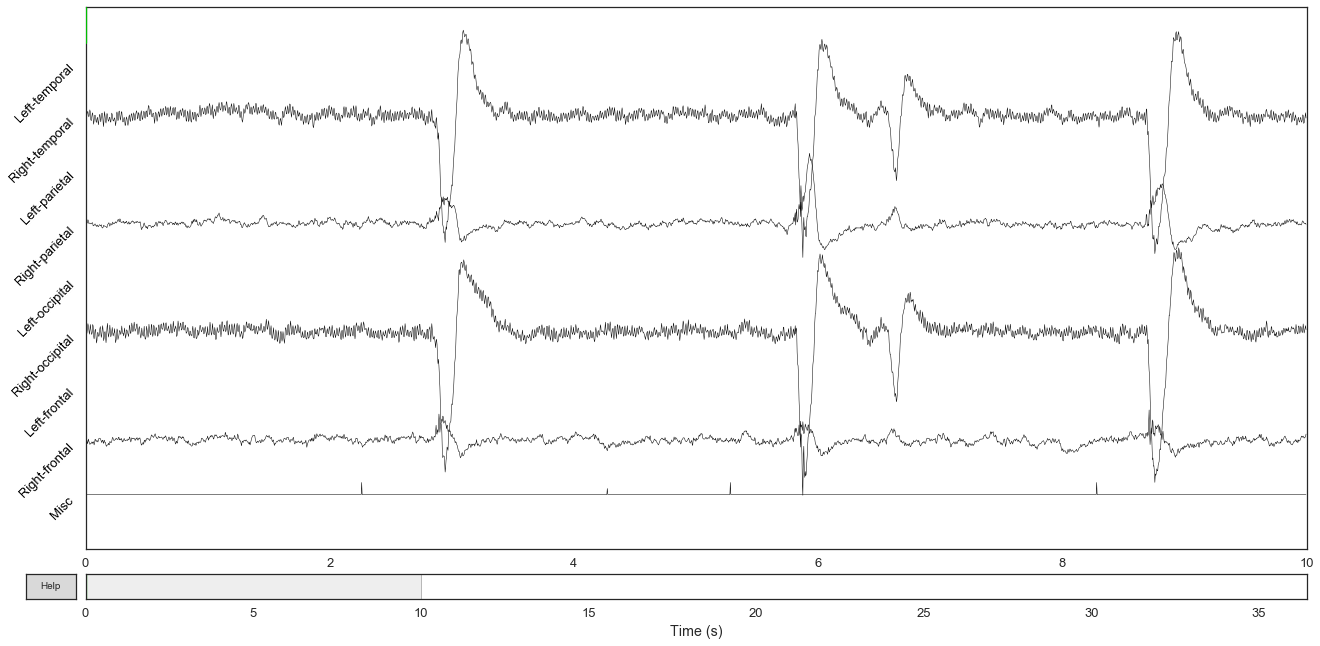

In [4]:
# explorar los datos
%matplotlib inline
raw_train.plot(butterfly=True, show=True, event_color='red', group_by='position');

Effective window size : 8.000 (s)


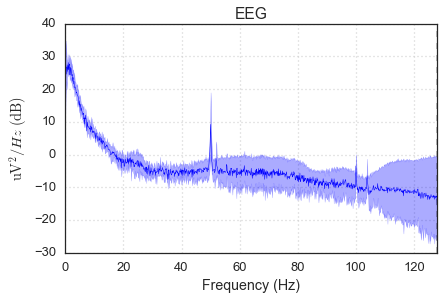

In [5]:
#ver espectro de frecuencia de los EEG
%matplotlib inline
raw_train.plot_psd(color=(0, 0, 1),
          show=False, average=True);

Como puede verse, existe un pico en 50Hz y un armónico en 100Hz en los datos crudos. Además, como se verá más adelante,  existe bastante ruido, sobre todo en los canales TP9 y TP10. En las siguientes secciones veremos distintos métodos de filtrado.

## Epoching
Se dividen los registros en Epochs entre -100ms y 800ms luego del evento. No se hace corrección a la baseline y NO se rechazan los eventos mayores a 100uV (mayormente parpadeos) porque es lo que se quiere clasificar.

36 matching events found
0 projection items activated
Loading data for 36 events and 283 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 845 samples (3.301 sec) selected
filter_length (845) is longer than the signal (283), distortion is likely. Reduce filter length or filter a longer signal.
Using filter length: 845
Smart-padding with:  282 samples on each edge
FFT block length:   1728


<ipython-input-29-a33428192f1c>:16: RuntimeWarning: filter_length (845) is longer than the signal (283), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_train.filter(1, 40 , fir_design='firwin')


Dropped 1 epoch


<Epochs  |  n_events : 35 (all good), tmin : -0.1015625 (s), tmax : 1.0 (s), baseline : None, ~329 kB, data loaded,
 'No parpadeo': 17, 'Parpadeo': 18>

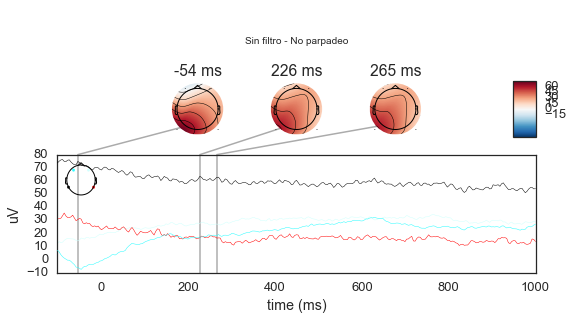

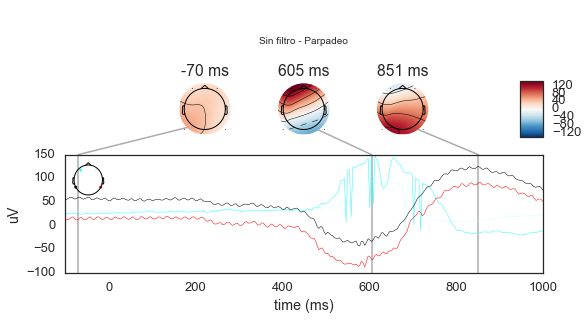

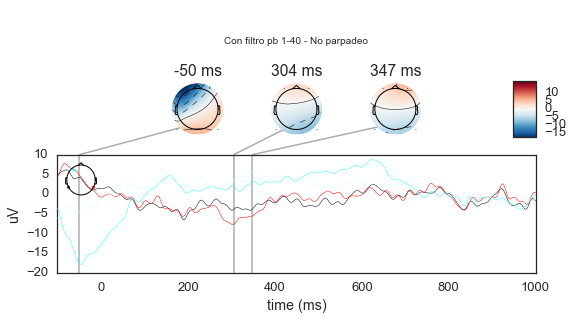

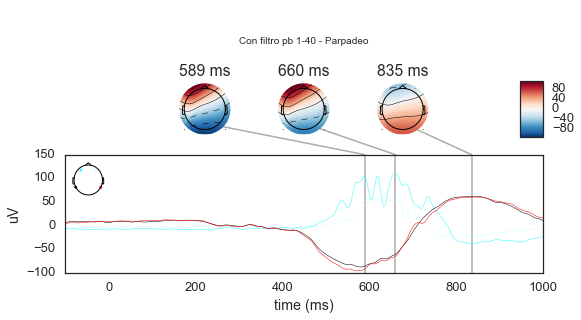

In [29]:
# descubrir eventos desde el EEG crudo
from mne import Epochs, find_events

events = find_events(raw_train, shortest_event=2, verbose='ERROR')
event_id = {'No parpadeo':1,'Parpadeo': 2}
# start of each epoch (100ms before the trigger)
tmin = -0.1    
# end of each epoch (800ms after the trigger)
tmax = 1.0
#normalmente la función de abajo toma otro comando reject = {eeg=some_value} para eliminar los epochs con ruido.
epochs_train = Epochs(raw_train, events=events, event_id=event_id,
                      tmin=tmin, tmax=tmax, baseline=None, preload=True,
                      verbose='DEBUG', picks=[0,1,2,3])
# visualizar epochs promedio sin filtrar
utils.plot_per_event(epochs_train, title="Sin filtro")
epochs_train.filter(1, 40 , fir_design='firwin')
#elimino el último porque puede quedar cortado
utils.plot_per_event(epochs_train, title="Con filtro pb 1-40")
epochs_train.drop([len(epochs_train)-1])
epochs_train
# incidentalmente, existe una función que encuentra automáticamente los artefactos del parpadeo
# pero requiere canales extra que indiquen cuando fue el artefacto.
#eog_events = preprocessing.find_eog_events(raw)

Resulta evidente si comparamos las gráficas, que hemos eliminado el ruido de alta frecuencia que afectaba a las curvas. Pero no se han eliminado los artefactos correspondientes a señales biológicas.

En la figura superior se han graficado los promedios de los 4 canales para los epochs correspondientes a los eventos de /Parpadeo/ y de /No parpadeo/. En las siguientes secciones se reproducirán las gráficas para poder evaluar la efectividad de las técnicas de filtrado.

In [32]:
#muestra los epochs. La presentación es interactiva y al hacer click sobre el Epoch, se los marca como malos
%matplotlib auto 
# block=True significa que la ejecución del programa se bloquea hasta que se cierre la figura
# útil si se quiere marcar canales on the fly.
event_colors = {1:'red',2:'blue'}
epochs_train.plot(block=True, events=events);
#epochs_train['Parpadeo'].plot_image()

Using matplotlib backend: Qt4Agg
Dropped 3 epochs
Channels marked as bad: []


In [41]:
# borrar los dos primeros, 
#epochs_train.drop([18,20,31,32])
clasificables['Epochs senial original']=epochs_train

## Filtrado - Independent Component Analysis

ICA es una técnica para revelar señales independientes (una señal es independiente si no se puede expresar como combinación de otra) que se encuentran combinadas de manera lineal en un conjunto de sensores. En este caso lo usaremos para encontrar artefactors (son señales independientes) y eliminarlos del análisis.
Por ejemplo dadas las curvas:
<img src="https://sccn.ucsd.edu/~arno/ica/m1m2.jpg"/>
Donde la primera es combinación de una curva A menos una curva B, y la segunda es 1.73*A+3.41*B, si procesamos ambas combinaciones con ICA, obtenemos las señales que le dan origen:
<img src="https://sccn.ucsd.edu/~arno/ica/fastica.jpg"/>

Aplicaremos ICA a los datos crudos (raw_train) y a los epochs.

In [34]:
# FIXME: ICA is sensitive to low-frequency drifts and therefore requires the data to be high-pass filtered prior to fitting.
from mne.preprocessing import ICA
# Aplico ICA a la señal cruda original
ica_raw = ICA(method='fastica').fit(raw_train)
epochs_ica_raw = Epochs(ica_raw.get_sources(raw_train), events=events, event_id=event_id,
                      tmin=tmin, tmax=tmax, baseline=None, preload=True,
                      verbose='ERROR', picks=[0,1,2,3])


# Aplico ICA a los epochs previamente creados
ica_epochs = ICA(method='fastica').fit(epochs_train)

Fitting ICA to data using 4 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 4
Fitting ICA to data using 4 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 4


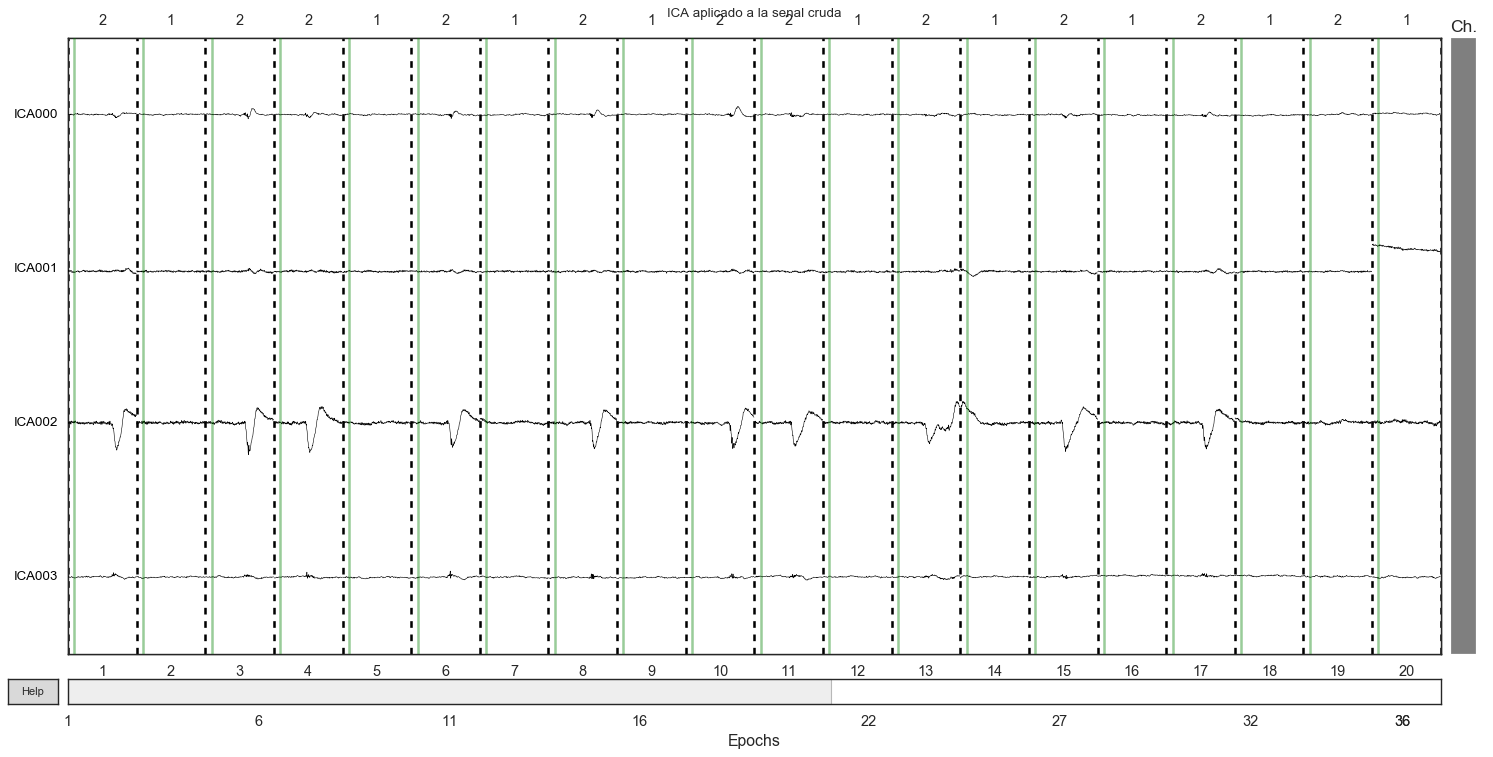

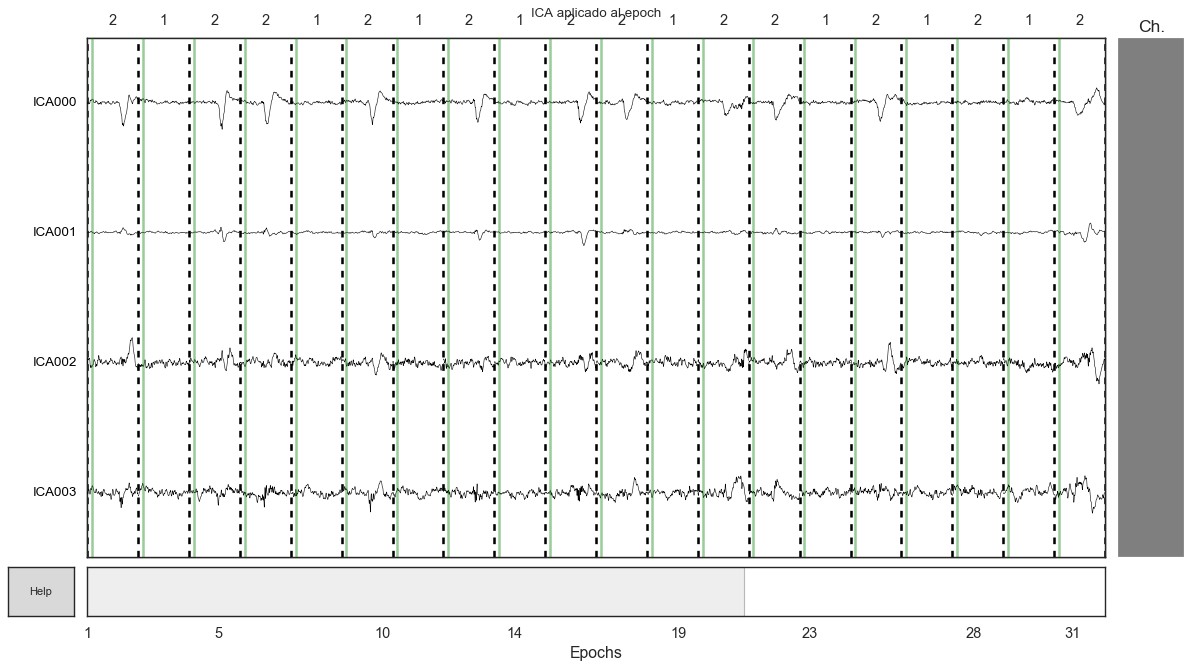

In [39]:
%matplotlib inline
# Plot estimated latent sources given the unmixing matrix.
epochs_ica_raw.plot(show=True, scalings='auto', title='ICA aplicado a la senal cruda');
ica_epochs.plot_sources(epochs_train, title='ICA aplicado al epoch');

Notar que las señales son levemente diferentes, pues son soluciones independientes, aún cuando han sido extraidas de la misma señal original.

In [40]:
# Agrego los objetos obtenidos a la lista de clasificables
clasificables['ICA senial cruda']= epochs_ica_raw
clasificables['ICA epochs'] = ica_epochs

## Filtro - xDAWN

Según la documentación de MNE es mejor que ICA, debería averiguar un poquito más igual. 



In [ ]:
from mne.preprocessing import Xdawn

In [ ]:
# Plot image epoch before xdawn
plot_epochs_image(epochs_train.pick_channels(['TP9','TP10']), vmin=-10, vmax=70)


In [ ]:
# Plot image epoch before xdawn
plot_epochs_image(epochs_train, vmin=-10, vmax=70)

En la figura anterior se muestra el promedio de los Epochs para los cuatro canales. Este sería el "patron" a detectar si sólo trabajamos en el dominio del tiempo. Se observa que el patrón bastante evidente. En la figura donde se ven los valores instantáneos de los Epochs se puede apreciar que los identificados como 1 y 2 no presentan la misma figura que los otros. Habrá pues que excluirlos.

#  Clasificación

En el contexto de EEG, al aprendizaje supervisado se le llama _decoding_ o también _multivariate pattern analysis (MPVA)_ 


In [45]:
#imports
from mne import io, EvokedArray
from mne.datasets import sample
from mne.decoding import Vectorizer, get_coef

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


# import a linear classifier from mne.decoding
from mne.decoding import LinearModel

In [46]:
# asigno las etiquetas a los eventos
labels = epochs_train.events[:, -1]
#labels

## Regresión logística

En primer instancia se deben escalar los datos. Al aplicar el scaler, el dataset queda con media cero y desviación estandar unitaria. Esto es necesario porque muchos métodos de ML asumen que así se presentarán los datos.

Luego see dividen los datos en dos sets, de entrenamiento y de pruebas. Con el segundo se verificarán los resultados del primero.

El clasificador usado en esta primera instancia es uno basado en regresión logística, como tal es uno de lo más básicos.


In [43]:
scaler = StandardScaler()

#reshape data
eeg_data_train = epochs_train.get_data().reshape(len(labels), -1)
# fit the classifier on MEG data
X = scaler.fit_transform(eeg_data_train)

y = epochs_train.events[:, 2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

y_train

array([2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2])

In [44]:
clf = LogisticRegression()

# create a linear model with LogisticRegression
model = LinearModel(clf)

model.fit(X_train, y_train)

LinearModel(model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))

Vemos que al evaluar las predicciones con el conjunto de datos reservados para pruebas, el clasificador tiene una precisión cercana o igual al 100%. No olvidemos que trabajamos con un tipo de evento (parpadeo) que es fácilmente reconocible en el EEG y que genera una deformación en las señales apreciables. Seguramente la exactitud no será tan alta con otro tipo de eventos.

In [45]:
clf.score(X_test, y_test)

1.0

Podemos graficar la intensidad de la distribución espacial de las señales en el dominio del tiempo con la siguiente función:

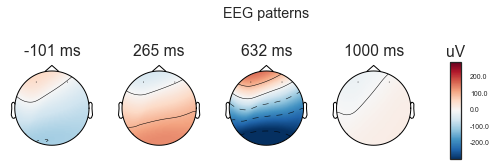

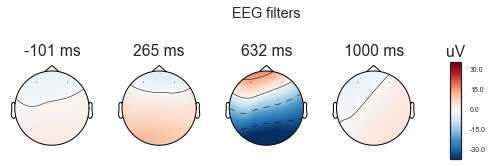

In [46]:
# Extract and plot spatial filters and spatial patterns
for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(epochs_train.ch_names), -1)

    # Plot
    evoked = EvokedArray(coef, epochs_train.info, tmin=epochs_train.tmin)
    evoked.plot_topomap(title='EEG %s' % name)


Esto que viene a continuación es lo mismo pero de otra manera. Notar que los gráficos producidos son idénticos. Estaría bueno estudiar si hay alguna diferencia real.

In [47]:
# manera alternativa de obtener el dataset, y de construir un pipeline
X = epochs_train.pick_types(meg=False, eeg=True)
y = epochs_train.events[:, 2]

# Define a unique pipeline to sequentially:
clf = make_pipeline(
    Vectorizer(),                       # 1) vectorize across time and channels
    StandardScaler(),                   # 2) normalize features across trials
    LinearModel(LogisticRegression()))  # 3) fits a logistic regression
clf.fit(X, y)


Pipeline(steps=[('vectorizer', <mne.decoding.transformer.Vectorizer object at 0x7fa47c146350>), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearmodel', LinearModel(model=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)))])

## Cross validation

Un problema que surge de optimizar hiperparámetros es que, si se usa el mismo test set y train set, se optimiza el modelo para un test set en particular y hay sobreajuste.

Una solución es usar _cross-validation_ (CV) con lo cual se reserva un test set para evaluar al clasificador, pero el train set se divide ahora k-subsets o k-folds. El modelo es entonces entrenado con (k-1) subsets y el restante se usa para validarlo. El proceso se puede repetir varias veces, con divisiones distintas de los subsets, y de esta manera obtener un promedio de la clasificación.



In [48]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.66666667  0.66666667  1.          1.          1.        ]
Accuracy: 0.87 (+/- 0.33)


Como se observa, en 5 ejecuciones, el clasificador obtuvo un porcentaje de éxito = 100% en 4 casos.

# Extracción de características

En esta sección voy a obtener características complementarias al Epoch (ventana de tiempo compuesta por cuatro canales), para ingresar como vector de entrada al clasificador.

## Potencia espectral


Esta es la potencia de los datos crudos. Como tal no sirve de mucho.

In [ ]:
from mne.time_frequency import psd_welch
potencia, freq = psd_welch(raw_train, fmax=40, fmin=1, n_fft=512)
potenciadB = 20 * np.log10(potencia)  # scale to dB
potenciadB.shape

In [ ]:
plt.figure()
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia(dB)')
plt.title('Potencia espectral de todo el conjunto, 4 canales')
for pot in potenciadB:
           plt.plot(freq, pot)
plt.show()

Ahora tengo que ver como integrar esto con los datos en el dominio del tiempo que llegan al clasificador. Hay una gran disparidad en el tamaño de los datos. Por sobre todas las cosas, así como está no sirve porque toma el conjunto entero de la señal, sin hacer diferencias entre los epochs.

Tomo entonces para cada Epoch su potencia espectral. Con una FFT de 256 puntos, tenemos una resolución de 1/1s = 1 Hz. Se puede aumentar la longitud de la FFT para obtener una mayor resolución y una reducción de la base de ruido, a cambio de mayor complejidad para realizar los cálculos. En cualquier caso la longitud de la FFT debe ser mayor o igual que la tasa de muestreo.

In [ ]:
potenciaEpoch, freq = psd_welch(epochs_train, fmax=40, fmin=1, n_fft=256)
#obtengo para cada epoch y para cada canal del epoch, el promedio de las frecuencias
print("Shape potenciaEpoch" + str(potenciaEpoch.shape))
potenciaAveraged = np.average(potenciaEpoch, axis=1) 
print("Shape potenciaAveraged: " +str(potenciaAveraged.shape))
potenciaAveraged = 20 * np.log10(potenciaAveraged)

# veamos como se observa el espectro de un epoch correspondiente a un 
plt.figure()
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Potencia(dB)')
plt.title('Potencia espectral')

parp, = plt.plot(freq, potenciaAveraged[0], label="Parpadeo")
no_parp, = plt.plot(freq, potenciaAveraged[1], label="No parpadeo")
plt.legend(handles=[parp, no_parp])
plt.show()

Ahora tengo 27 epochs, cada uno con su correspondiente etiqueta y por cada Epoch, 40 muestras correspondientes a los 4 canales promediados. El vector de entrada al clasificador va a estar conformado por los cuatro canales, y alguna otra estadística que se me ocurra.

In [ ]:
from sklearn import tree
# ajustar el clasificador a los datos de potencia
X_potencia = scaler.fit_transform(potenciaAveraged)
# usamos el mismo y, porque el orden de las etiquetas no ha cambiado
# y = epochs_train.events[:, 2]

X_potencia_train, X_potencia_test, y_potencia_train, y_potencia_test = train_test_split(X_potencia, y, test_size=0.3)
#potenciaAveraged[1]
# Define a unique pipeline to sequentially:
clf = make_pipeline(
    Vectorizer(),                       # 1) vectorize across time and channels
    StandardScaler(),                   # 2) normalize features across trials
    tree.DecisionTreeClassifier())  # 3) fits a logistic regression
clf.fit(X_potencia_train, y_potencia_train)

scores = cross_val_score(clf, X_potencia_train, y_potencia_train, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Los valores de exactitud alcanzados no difieren mucho de los obtenidos con un vector de entrada representado por el valor delos elementos en el dominio del tiempo. Hay que ver si esta afirmación se mantiene para otro tipo de problemas

# TODO
- TODO mne.set_eeg_reference (incluir referencia para mejorar SNR?)
- TODO Aplicar filtros como CSP, aunque lo dejaría para el final, así comparo cómo funciona con y sin filtros.
- TODO ICA Preprocessing for artifact supression
- TODO Epoching on the fly
- TODO http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [ ]:
from sklearn.tree import DecisionTreeClassifier
X1 = epochs_train.pick_types(meg=False, eeg=True)
y1 = epochs_train.events[:, 2]

# Define a unique pipeline to sequentially:
clf = make_pipeline(
    Vectorizer(),                       # 1) vectorize across time and channels
    StandardScaler(),                   # 2) normalize features across trials
    DecisionTreeClassifier())  # 3) fits a logistic regression
clf.fit(X, y)

In [ ]:
y_predicted = clf.predict(X_test)

In [ ]:
Xs = epochs_train.get_data()
times = epochs_train.times
ys = pd.Series(epochs_train.events[:, -1])


In [ ]:
#   for ch in range(4):
#        for cond, color in zip(conditions.values(), palette):
#            sns.tsplot(X[y.isin(cond), ch], time=times, color=color,
#                       n_boot=n_boot, ci=ci, ax=axes[ch])
if True:
    palette = sns.color_palette("hls", len(conditions) + 1)

fig, axes = plt.subplots(2, 2, figsize=[12, 6],
                         sharex=True, sharey=True)

axes = [axes[1, 0], axes[0, 0], axes[0, 1], axes[1, 1]]

for cond, color in zip(conditions.values(),palette):
    sns.tsplot(Xs[ys.isin(cond), 1], time=times, color=color,
                       n_boot=1000, ci=0.95, ax=axes[1])


In [ ]:
Xs[ys.isin([0,1]),1].shape

In [ ]:
conditions.values()

In [ ]:
Xs[ys.isin([4]),1] == Xs[ys.isin([1]),1]

In [ ]:
Xs[ys.isin([2]),1] == Xs[ys.isin([1,0]),1]

In [ ]:
epochs_train.events